# Data analysis

#### Description of data and aims:
In the summer of 2024, a mysterious disease dubbed the “pundemic” by the media began cropping up worldwide. Diseased patients make puns at every opportunity. A link between the pundemic and changes in the gut microbiome was discovered, and a doctor at the USZ set up a clinical trial using fecal microbiota transplants (FMT) as a possible treatment.

Trial data:  
Collection of fecal microbiome samples from pundemic patients before and after the trial, from both treatment and placebo groups. Pundemic severity in patients was quantified in terms of puns per hour. Fecal samples were collected from the FMT donors as well.

Because the bacterial and fungal gut microbiome are both of interest, the USZ team collected both **16S rRNA gene** and **ITS** data from the study cohort. 

Aims:
1. Analyzing the ITS data in order to further explore the connection between pundemic symptoms and an altered gut mycobiome composition
2. Analyzing the potential of FMT as a pandemic treatment option. You have received DNA sequences as well as metadata allowing you to distinguish pundemic from healthy samples.


In [2]:
# Package import
import os
import pandas as pd
from qiime2 import Visualization
import matplotlib.pyplot as plt
import numpy as np
import qiime2 as q2
import seaborn as sns

%matplotlib inline

In [4]:
data_dir = 'data'

## Data import and denoising

In [3]:
# Data and metadata import
#! wget -O data/raw/pundemic_metadata.tsv https://polybox.ethz.ch/index.php/s/7LxWSbaw2q37yof/download
#! wget -O data/raw/pundemic_forward_reads.qza https://polybox.ethz.ch/index.php/s/o8HqHJqvuf9e2on/download


In [4]:
meta_df = pd.read_csv('data/pundemic_metadata.tsv', sep='\t', index_col=0)

# Metadata df creation and overview
meta_df = pd.read_csv(f'{data_dir}/pundemic_metadata.tsv', sep='\t', index_col=0)

In [5]:
meta_df.head()

,patient_id,age,sex,ethnicity,continent,country,region,city,group,disease_subgroup,blinded_clinical_response,puns_per_hour_pre_treatment,puns_per_hour_post_treatment,time_point
id,,,,,,,,,,,,,,
SRR10505051,1048,36,female,Caucasian,Europe,Switzerland,Zurich,Zurich,Puns,Placebo,NR,9.0,8.0,post-treatment
SRR10505052,1048,36,female,Caucasian,Europe,Switzerland,Zurich,Zurich,Puns,Placebo,NR,9.0,8.0,pre-treatment
SRR10505053,1045,29,male,Caucasian,Europe,Switzerland,Zurich,Zurich,Puns,Placebo,Res,6.0,0.0,pre-treatment
SRR10505054,1045,29,male,Caucasian,Europe,Switzerland,Zurich,Zurich,Puns,Placebo,Res,6.0,0.0,post-treatment
SRR10505055,1044,34,male,Indian Subcontinental,Europe,Switzerland,Zurich,Zurich,Puns,Placebo,NaN,4.0,NaN,pre-treatment


In [6]:
# We have 3 groups, placebo FMT and donor
meta_df['disease_subgroup'].unique() 

array(['Placebo', 'FMT', 'donor'], dtype=object)

In [7]:
# Creating DFs of our different populations for later use
patient_df = meta_df[(meta_df['disease_subgroup'] == "placebo") | (meta_df['disease_subgroup'] == "FMT")]
patient_df.to_csv(f'{data_dir}/patient_df', sep = '\t')

In [8]:
donor_df = meta_df[(meta_df['disease_subgroup'] == "donor")]
donor_df.to_csv(f'{data_dir}/donor_df', sep = '\t')

In [9]:
meta_df[(meta_df['time_point'] == "pre-treatment") | (meta_df['time_point'] == "post-treatment")]

,patient_id,age,sex,ethnicity,continent,country,region,city,group,disease_subgroup,blinded_clinical_response,puns_per_hour_pre_treatment,puns_per_hour_post_treatment,time_point
id,,,,,,,,,,,,,,
SRR10505051,1048,36,female,Caucasian,Europe,Switzerland,Zurich,Zurich,Puns,Placebo,NR,9.0,8.0,post-treatment
SRR10505052,1048,36,female,Caucasian,Europe,Switzerland,Zurich,Zurich,Puns,Placebo,NR,9.0,8.0,pre-treatment
SRR10505053,1045,29,male,Caucasian,Europe,Switzerland,Zurich,Zurich,Puns,Placebo,Res,6.0,0.0,pre-treatment
SRR10505054,1045,29,male,Caucasian,Europe,Switzerland,Zurich,Zurich,Puns,Placebo,Res,6.0,0.0,post-treatment
SRR10505055,1044,34,male,Indian Subcontinental,Europe,Switzerland,Zurich,Zurich,Puns,Placebo,NaN,4.0,NaN,pre-treatment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR10505141,1001,57,female,Caucasian,Europe,Switzerland,Zurich,Zurich,Puns,FMT,Res,7.0,2.0,pre-treatment
SRR10505142,1001,57,female,Caucasian,Europe,Switzerland,Zurich,Zurich,Puns,FMT,Res,7.0,2.0,post-treatment
SRR10505153,2225,34,male,Caucasian,Europe,Switzerland,Zurich,Zurich,Puns,FMT,NR,6.0,5.0,pre-treatment


From initial exploration, there are 105 samples from different groups:

- Donor of the FMT treatment group
- Placebo treatment
- FMT treatment

And we also have different timepoints of data colleciton, pre and post treatment.

### Further metadata explorination

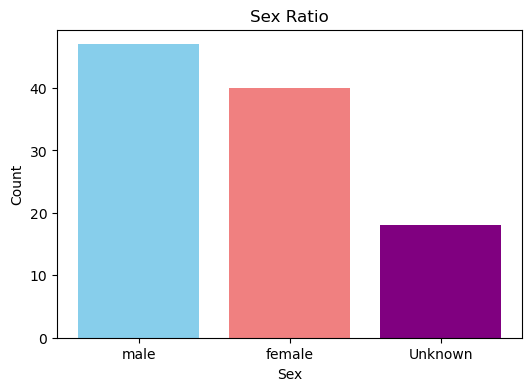

In [10]:
# Gender data

sex_counts = meta_df['sex'].value_counts()

# Create a barplot
plt.figure(figsize=(6, 4))
plt.bar(sex_counts.index, sex_counts.values, color=['skyblue', 'lightcoral', 'purple'])
plt.xlabel('Sex')
plt.ylabel('Count')
plt.title('Sex Ratio')
plt.show()

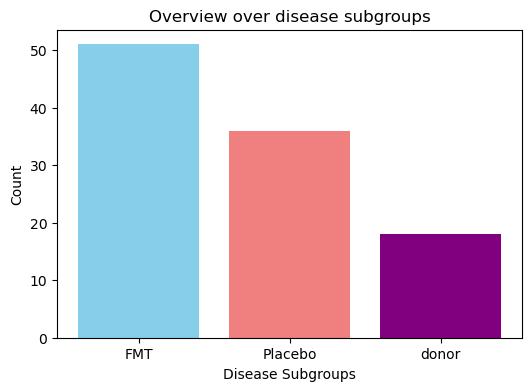

In [11]:
# Group spread

disease_counts = meta_df['disease_subgroup'].value_counts()

# Create a barplot
plt.figure(figsize=(6, 4))
plt.bar(disease_counts.index, disease_counts.values, color=['skyblue', 'lightcoral', 'purple'])
plt.xlabel('Disease Subgroups')
plt.ylabel('Count')
plt.title('Overview over disease subgroups')
plt.show()

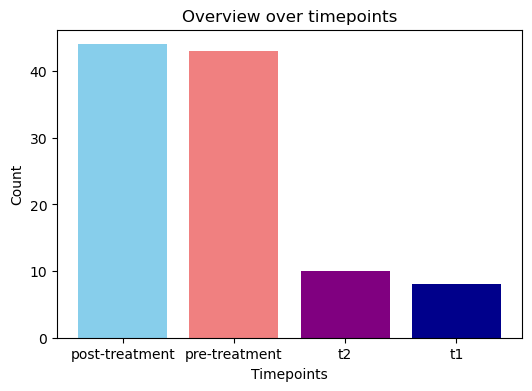

In [12]:
# Timepoints

time_counts = meta_df['time_point'].value_counts()

# Create a barplot
plt.figure(figsize=(6, 4))
plt.bar(time_counts.index, time_counts.values, color=['skyblue', 'lightcoral', 'purple', 'darkblue'])
plt.xlabel('Timepoints')
plt.ylabel('Count')
plt.title('Overview over timepoints')
plt.show()

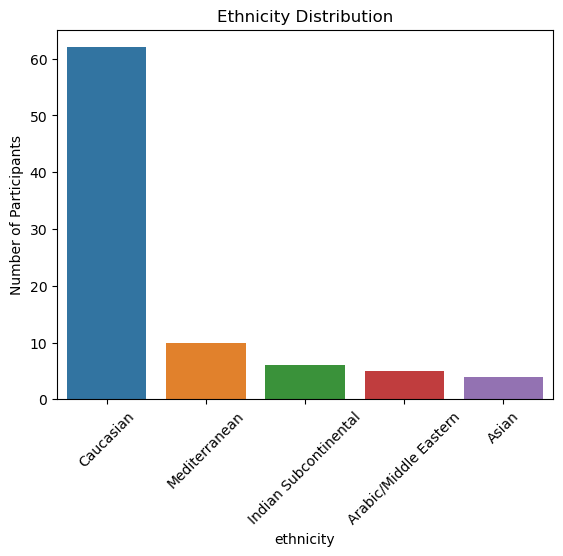

In [13]:
#ethnicity distribution
sns.countplot(data = meta_df, x='ethnicity', order=meta_df['ethnicity'].value_counts().index)
plt.title("Ethnicity Distribution")
plt.xticks(rotation=45)
plt.ylabel("Number of Participants")
plt.show()

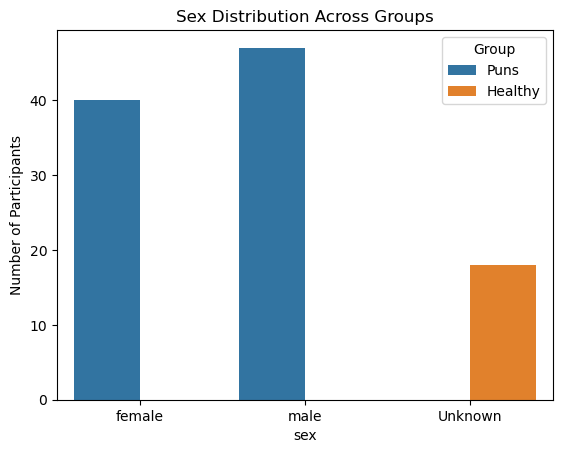

In [14]:
#Sex Distribution Across Groups
sns.countplot(data=meta_df, x='sex', hue='group')
plt.title("Sex Distribution Across Groups")
plt.ylabel("Number of Participants")
plt.legend(title="Group")
plt.show()

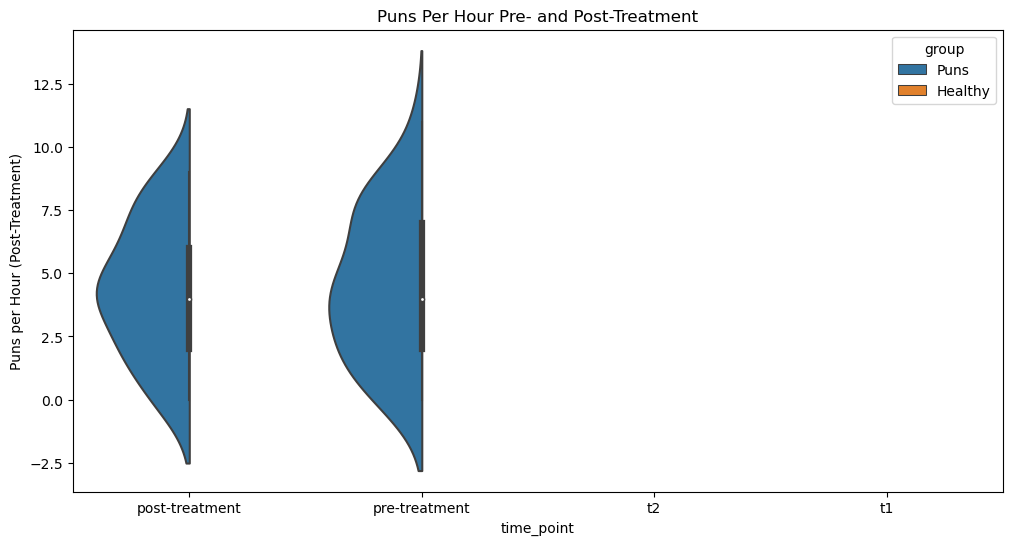

In [15]:
#Puns per Hour Pre- and Post-Treatment
plt.figure(figsize=(12, 6))
sns.violinplot(data = meta_df, x = 'time_point', y = 'puns_per_hour_post_treatment', hue='group', split=True)
plt.title("Puns Per Hour Pre- and Post-Treatment")
plt.ylabel("Puns per Hour (Post-Treatment)")
plt.show()

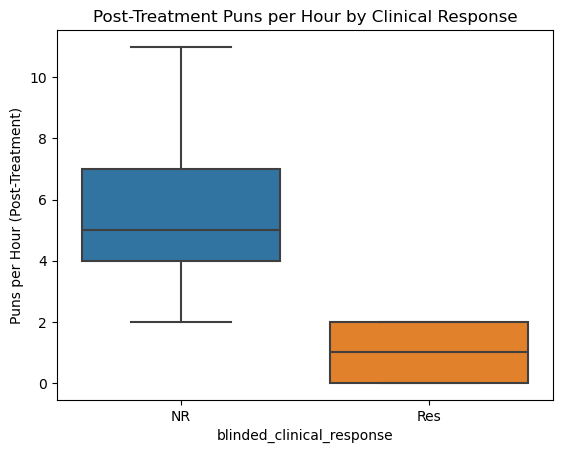

In [16]:
#Blinded Clinical Response Analysis
sns.boxplot(data=meta_df, x='blinded_clinical_response', y='puns_per_hour_post_treatment')
plt.title("Post-Treatment Puns per Hour by Clinical Response")
plt.ylabel("Puns per Hour (Post-Treatment)")
plt.show()

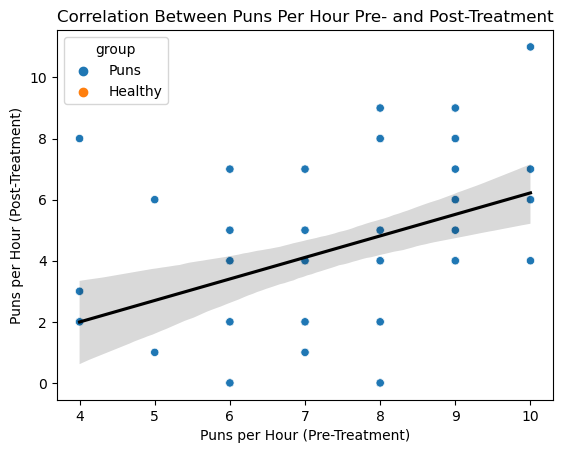

In [17]:
#Correlation Between Puns per Hour Pre- and Post-Treatment
sns.scatterplot(data=meta_df, x='puns_per_hour_pre_treatment', y='puns_per_hour_post_treatment', hue='group')
sns.regplot(data=meta_df, x='puns_per_hour_pre_treatment', y='puns_per_hour_post_treatment', scatter=False, color='black')
plt.title("Correlation Between Puns Per Hour Pre- and Post-Treatment")
plt.xlabel("Puns per Hour (Pre-Treatment)")
plt.ylabel("Puns per Hour (Post-Treatment)")
plt.show()

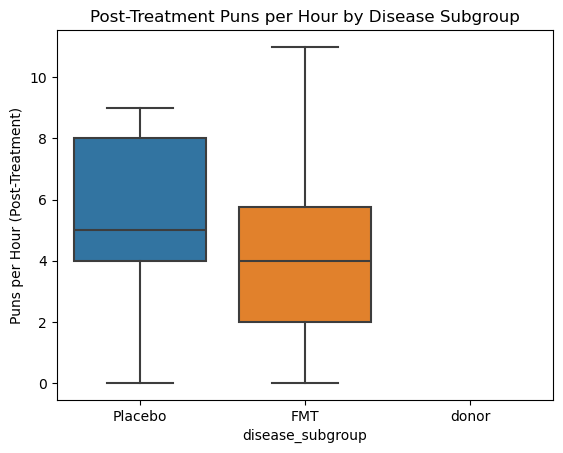

In [18]:
#Puns per Hour Across Disease Subgroups
sns.boxplot(data=meta_df, x='disease_subgroup', y='puns_per_hour_post_treatment')
plt.title("Post-Treatment Puns per Hour by Disease Subgroup")
plt.ylabel("Puns per Hour (Post-Treatment)")
plt.show()

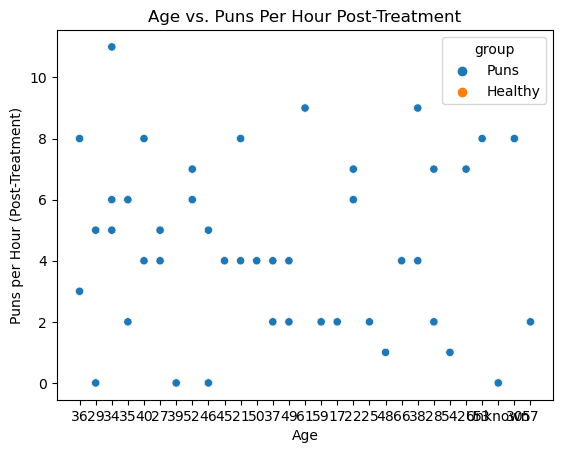

In [19]:
#Age vs. Puns per Hour Post-Treatment
sns.scatterplot(data=meta_df, x='age', y='puns_per_hour_post_treatment', hue='group')
plt.title("Age vs. Puns Per Hour Post-Treatment")
plt.xlabel("Age")
plt.ylabel("Puns per Hour (Post-Treatment)")
plt.show()

## Sequence Import

In [20]:
! qiime tools peek $data_dir/pundemic_forward_reads.qza

UUID:        15b104e4-bd22-4469-92ac-e08f76767733
Type:        SampleData[SequencesWithQuality]
Data format: SingleLanePerSampleSingleEndFastqDirFmt


In [21]:
! qiime demux summarize \
    --i-data $data_dir/pundemic_forward_reads.qza \
    --o-visualization $data_dir/pundemic_forward_reads.qzv

Saved Visualization to: data/pundemic_forward_reads.qzv


In [22]:
Visualization.load(f"{data_dir}/pundemic_forward_reads.qzv")

<visualization: Visualization uuid: 2e38af6f-e6a2-4a3e-a5e4-c7cd9d2cf1f7>

From this summary, we find that our samples have around a 10 fold spread in terms of sample reads, with the median around 44,000. We have been informed by the TAs there were primers still in this dataset, which we remove in the following cells:

## Check for primer sequences in data

In [23]:
# 99-100% of reads include the primer.

! qiime cutadapt trim-single \
  --i-demultiplexed-sequences $data_dir/pundemic_forward_reads.qza \
  --p-front CTTGGTCATTTAGAGGAAGTAA \
  --p-error-rate 0.2 \
  --p-discard-untrimmed \
  --verbose \
  --o-trimmed-sequences $data_dir/pundemic_forward_reads_trimmed.qza | tee $data_dir/cutadaptresults.log 

This is cutadapt 4.9 with Python 3.9.19
Command line parameters: --cores 1 --error-rate 0.2 --times 1 --overlap 3 --minimum-length 1 -q 0,0 --quality-base 33 -o /tmp/q2-CasavaOneEightSingleLanePerSampleDirFmt-6pl8e43p/SRR10505051_00_L001_R1_001.fastq.gz --front CTTGGTCATTTAGAGGAAGTAA --discard-untrimmed /tmp/qiime2/jovyan/data/15b104e4-bd22-4469-92ac-e08f76767733/data/SRR10505051_00_L001_R1_001.fastq.gz
Processing single-end reads on 1 core ...
Done           00:00:00        37,345 reads @  19.6 µs/read;   3.07 M reads/minute
Finished in 0.733 s (19.634 µs/read; 3.06 M reads/minute).

=== Summary ===

Total reads processed:                  37,345
Reads with adapters:                    37,290 (99.9%)

== Read fate breakdown ==
Reads that were too short:                   0 (0.0%)
Reads written (passing filters):        37,290 (99.9%)

Total basepairs processed:     9,336,250 bp
Quality-trimmed:                       0 bp (0.0%)
Total written (filtered):      8,517,104 bp (91.2%)

=== 

In [24]:
! qiime cutadapt trim-single --help

Usage: qiime cutadapt trim-single [OPTIONS]

  Search demultiplexed single-end sequences for adapters and remove them. The
  parameter descriptions in this method are adapted from the official cutadapt
  docs - please see those docs at https://cutadapt.readthedocs.io for complete
  details.

Inputs:
  --i-demultiplexed-sequences ARTIFACT SampleData[SequencesWithQuality]
                        The single-end sequences to be trimmed.     [required]
Parameters:
  --p-cores NTHREADS    Number of CPU cores to use.               [default: 1]
  --p-adapter TEXT...   Sequence of an adapter ligated to the 3' end. The
    List[Str]           adapter and any subsequent bases are trimmed. If a `$`
                        is appended, the adapter is only found if it is at the
                        end of the read. If your sequence of interest is
                        "framed" by a 5' and a 3' adapter, use this parameter
                        to define a "linked" primer - see
                

In [25]:
# trim reverse compliment of backward primer at 3'end of sequence
# requires at least 8 bases of overlap for adapter to be found

! qiime cutadapt trim-single \
  --i-demultiplexed-sequences $data_dir/pundemic_forward_reads_trimmed.qza \
  --p-cores 6 \
  --p-adapter GCATCGATGAAGAACGCAGC \
  --p-error-rate 0.2 \
  --p-overlap 8 \
  --verbose \
  --o-trimmed-sequences $data_dir/pundemic_forward_reads_trimmed_backtrimmed.qza | tee $data_dir/cutadapt_forward_backward_results.log

This is cutadapt 4.9 with Python 3.9.19
Command line parameters: --cores 6 --error-rate 0.2 --times 1 --overlap 8 --minimum-length 1 -q 0,0 --quality-base 33 -o /tmp/q2-CasavaOneEightSingleLanePerSampleDirFmt-h8so8bz4/SRR10505051_00_L001_R1_001.fastq.gz --adapter GCATCGATGAAGAACGCAGC /tmp/qiime2/jovyan/data/71c8057e-38d0-4e51-a1b3-ee87c6ce39df/data/SRR10505051_00_L001_R1_001.fastq.gz
Processing single-end reads on 6 cores ...
Done           00:00:00        37,290 reads @   7.1 µs/read;   8.40 M reads/minute
Finished in 0.339 s (9.097 µs/read; 6.60 M reads/minute).

=== Summary ===

Total reads processed:                  37,290
Reads with adapters:                    15,483 (41.5%)

== Read fate breakdown ==
Reads that were too short:                   6 (0.0%)
Reads written (passing filters):        37,284 (100.0%)

Total basepairs processed:     8,517,104 bp
Quality-trimmed:                       0 bp (0.0%)
Total written (filtered):      8,213,167 bp (96.4%)

=== Adapter 1 ===

Sequ

In [26]:
# trim reverse compliment of backward primer at 3'end of sequence

! qiime cutadapt trim-single \
  --i-demultiplexed-sequences $data_dir/pundemic_forward_reads_trimmed.qza \
  --p-cores 6 \
  --p-adapter GCATCGATGAAGAACGCAGC \
  --p-error-rate 0.3 \
  --p-overlap 8 \
  --verbose \
  --o-trimmed-sequences $data_dir/pundemic_forward_reads_trimmed_backtrimmed_03.qza | tee $data_dir/cutadapt_forward_backward_03_results.log

This is cutadapt 4.9 with Python 3.9.19
Command line parameters: --cores 6 --error-rate 0.3 --times 1 --overlap 8 --minimum-length 1 -q 0,0 --quality-base 33 -o /tmp/q2-CasavaOneEightSingleLanePerSampleDirFmt-oo5ud0wp/SRR10505051_00_L001_R1_001.fastq.gz --adapter GCATCGATGAAGAACGCAGC /tmp/qiime2/jovyan/data/71c8057e-38d0-4e51-a1b3-ee87c6ce39df/data/SRR10505051_00_L001_R1_001.fastq.gz
Processing single-end reads on 6 cores ...
Done           00:00:00        37,290 reads @   7.4 µs/read;   8.08 M reads/minute
Finished in 0.356 s (9.542 µs/read; 6.29 M reads/minute).

=== Summary ===

Total reads processed:                  37,290
Reads with adapters:                    18,074 (48.5%)

== Read fate breakdown ==
Reads that were too short:                   8 (0.0%)
Reads written (passing filters):        37,282 (100.0%)

Total basepairs processed:     8,517,104 bp
Quality-trimmed:                       0 bp (0.0%)
Total written (filtered):      8,055,699 bp (94.6%)

=== Adapter 1 ===

Sequ

In [27]:
#ITS1F primer: CTTGGTCATTTAGAGGAAGTAA
#ITS2R primer: GCTGCGTTCTTCATCGATGC
#Forward overhang: 5’-TCGTCGGCAGCGTCAGATGTGTATAAGAGACAG-[locus-specific sequence]
#Reverse overhang: 5’-GTCTCGTGGGCTCGGAGATGTGTATAAGAGACAG-[locus-specific sequence]

#error rate: 0.1 --> 99.4%
#error rate: 0.2 --> 99.9%

In [28]:
! qiime demux summarize \
    --i-data $data_dir/pundemic_forward_reads_trimmed.qza \
    --o-visualization $data_dir/pundemic_forward_reads_trimmed.qzv

Saved Visualization to: data/pundemic_forward_reads_trimmed.qzv


In [29]:
Visualization.load(f"{data_dir}/pundemic_forward_reads_trimmed.qzv")

<visualization: Visualization uuid: 92a31c51-b581-4e08-b428-99e788231311>

In [30]:
! qiime demux summarize \
    --i-data $data_dir/pundemic_forward_reads_trimmed_backtrimmed.qza \
    --o-visualization $data_dir/pundemic_forward_reads_trimmed_backtrimmed.qzv

Saved Visualization to: data/pundemic_forward_reads_trimmed_backtrimmed.qzv


In [3]:
Visualization.load(f"{data_dir}/pundemic_forward_reads_trimmed_backtrimmed.qzv")

NameError: name 'data_dir' is not defined

In [32]:
# Filtering out reads based on a minimum quality of 15

! qiime quality-filter q-score \
    --i-demux $data_dir/pundemic_forward_reads_trimmed_backtrimmed.qza \
    --p-min-quality 15 \
    --p-cores 6 \
    --p-quality-window 3 \
    --o-filtered-sequences $data_dir/pundemic_forward_reads_trimmed_backtrimmed_QCfiltered.qza \
    --o-filter-stats $data_dir/pundemic_forward_reads_trimmed_backtrimmed_QCfiltered_stats.qza

Usage: qiime quality-filter q-score [OPTIONS]

  This method filters sequence based on quality scores and the presence of
  ambiguous base calls.

Inputs:
  --i-demux ARTIFACT SampleData[SequencesWithQuality |
    PairedEndSequencesWithQuality]¹ | SampleData[JoinedSequencesWithQuality]²
                       The demultiplexed sequence data to be quality
                       filtered.                                    [required]
Parameters:
  --p-min-quality INTEGER
                       The minimum acceptable PHRED score. All PHRED scores
                       less that this value are considered to be low PHRED
                       scores.                                    [default: 4]
  --p-quality-window INTEGER
                       The maximum number of low PHRED scores that can be
                       observed in direct succession before truncating a
                       sequence read.                             [default: 3]
  --p-min-length-fraction NUMBER
        

In [33]:
! qiime demux summarize \
    --i-data $data_dir/pundemic_forward_reads_trimmed_backtrimmed_QCfiltered.qza \
    --o-visualization $data_dir/pundemic_forward_reads_trimmed_backtrimmed_QCfiltered.qzv

Usage: qiime demux summarize [OPTIONS]

  Summarize counts per sample for all samples, and generate interactive
  positional quality plots based on `n` randomly selected sequences.

Inputs:
  --i-data ARTIFACT SampleData[SequencesWithQuality |
    PairedEndSequencesWithQuality | JoinedSequencesWithQuality]
                       The demultiplexed sequences to be summarized.
                                                                    [required]
Parameters:
  --p-n INTEGER        The number of sequences that should be selected at
                       random for quality score plots. The quality plots will
                       present the average positional qualities across all of
                       the sequences selected. If input sequences are paired
                       end, plots will be generated for both forward and
                       reverse reads for the same `n` sequences.
                                                              [default: 10000]
Outputs:

In [34]:
Visualization.load(f"{data_dir}/pundemic_forward_reads_trimmed_QCfiltered.qzv")

<visualization: Visualization uuid: 45663ba1-0a2f-49da-a3f6-41b6f50f3c9f>

Through this process of filtering we are left with:

7,977,313 starting reads

7,953,426 after primer trimming (removing untrimmed)

5,650,800 after quality score filtering (trimming the read if more than 3 bases in a row under 15)

## Denoising
Our sequences originate from the ITS-1 region and were sequenced on an Illumina MiSeq machine. The sequence files contain demultiplexed single-end sequences.

We're using DADA2. It removes chimeras from our demuxed data. The output of applying DADA gives us features which are representative sequences for organisms.

Approaches we've tried:
 
Not trimming the data (p-trun-len = 0). We almost no classification with this approach.

Trimming the data after 129 nucleotides (at 130 first time 25 per centile quality score dropped below 20). We had poor classification with this approach.

Trimming the data after 140. Ok classificaiton for some samples, but none for others. 

### Denoising with trimmed and quality filtered reads

In [35]:
# Dada2 denoising using 140 truncation length

! qiime dada2 denoise-single \
    --i-demultiplexed-seqs $data_dir/pundemic_forward_reads_trimmed_backtrimmed_QCfiltered.qza \
    --p-trunc-len 145 \
    --p-n-threads 5 \
    --o-table $data_dir/dada/dada2_table.qza \
    --o-representative-sequences $data_dir/dada/dada2_rep_seq.qza \
    --o-denoising-stats $data_dir/dada/dada2_stats.qza

Usage: qiime dada2 denoise-single [OPTIONS]

  This method denoises single-end sequences, dereplicates them, and filters
  chimeras.

Inputs:
  --i-demultiplexed-seqs ARTIFACT SampleData[SequencesWithQuality |
    PairedEndSequencesWithQuality]
                          The single-end demultiplexed sequences to be
                          denoised.                                 [required]
Parameters:
  --p-trunc-len INTEGER   Position at which sequences should be truncated due
                          to decrease in quality. This truncates the 3' end of
                          the of the input sequences, which will be the bases
                          that were sequenced in the last cycles. Reads that
                          are shorter than this value will be discarded. If 0
                          is provided, no truncation or length filtering will
                          be performed                              [required]
  --p-trim-left INTEGER   Position at which se

In [36]:
! qiime metadata tabulate \
    --m-input-file $data_dir/dada/dada2_stats.qza \
    --o-visualization $data_dir/dada/dada2_stats.qzv

Saved Visualization to: data/dada/dada2_stats.qzv


In [37]:
Visualization.load(f"{data_dir}/dada/dada2_stats.qzv")

<visualization: Visualization uuid: 8179a0e9-b9dc-4d5e-8f94-9b8143d9b567>

In [38]:
! qiime feature-table tabulate-seqs \
    --i-data $data_dir/dada/dada2_rep_seq.qza \
    --o-visualization $data_dir/dada/dada2_rep_seq.qzv

Saved Visualization to: data/dada/dada2_rep_seq.qzv


In [5]:
Visualization.load(f"{data_dir}/dada/dada2_rep_seq.qzv")

<visualization: Visualization uuid: 00542eb2-ab78-4a5a-9b93-3e446ab8cee2>

We can also visualize the feature table. We will include the metadata file to enrich the table with information on sample groups.

In [40]:
! qiime feature-table summarize \
    --i-table $data_dir/dada/dada2_table.qza \
    --m-sample-metadata-file $data_dir/pundemic_metadata.tsv \
    --o-visualization $data_dir/dada/dada2_table.qzv

Saved Visualization to: data/dada/dada2_table.qzv


In [41]:
Visualization.load(f"{data_dir}/dada/dada2_table.qzv")

<visualization: Visualization uuid: d4c56995-c7fb-42c1-94ed-8210f0d3cf19>

### Denoising with trimmed reads

In [42]:
# Dada2 denoising using 140 truncation length

! qiime dada2 denoise-single \
    --i-demultiplexed-seqs $data_dir/pundemic_forward_reads_trimmed_backtrimmed.qza \
    --p-trunc-len 145 \
    --p-n-threads 5 \
    --o-table $data_dir/dada_no_qcfiltering/dada2_table.qza \
    --o-representative-sequences $data_dir/dada_no_qcfiltering/dada2_rep_seq.qza \
    --o-denoising-stats $data_dir/dada_no_qcfiltering/dada2_stats.qza

Saved FeatureTable[Frequency] to: data/dada_no_qcfiltering/dada2_table.qza
Saved FeatureData[Sequence] to: data/dada_no_qcfiltering/dada2_rep_seq.qza
Saved SampleData[DADA2Stats] to: data/dada_no_qcfiltering/dada2_stats.qza


In [43]:
! qiime metadata tabulate \
    --m-input-file $data_dir/dada_no_qcfiltering/dada2_stats.qza \
    --o-visualization $data_dir/dada_no_qcfiltering/dada2_stats.qzv

Saved Visualization to: data/dada_no_qcfiltering/dada2_stats.qzv


In [44]:
Visualization.load(f"{data_dir}/dada_no_qcfiltering/dada2_stats.qzv")

<visualization: Visualization uuid: 6228ec5f-d84f-4a34-902b-69b7be35cd50>

In [45]:
! qiime feature-table tabulate-seqs \
    --i-data $data_dir/dada_no_qcfiltering/dada2_rep_seq.qza \
    --o-visualization $data_dir/dada_no_qcfiltering/dada2_rep_seq.qzv

Saved Visualization to: data/dada_no_qcfiltering/dada2_rep_seq.qzv


In [46]:
Visualization.load(f"{data_dir}/dada_no_qcfiltering/dada2_rep_seq.qzv")

<visualization: Visualization uuid: 7f344d10-4b8c-40ad-bda4-d675d579b594>

In [47]:
! qiime feature-table summarize \
    --i-table $data_dir/dada_no_qcfiltering/dada2_table.qza \
    --m-sample-metadata-file $data_dir/pundemic_metadata.tsv \
    --o-visualization $data_dir/dada_no_qcfiltering/dada2_table.qzv

Saved Visualization to: data/dada_no_qcfiltering/dada2_table.qzv


In [48]:
Visualization.load(f"{data_dir}/dada_no_qcfiltering/dada2_table.qzv")

<visualization: Visualization uuid: 4abd1810-b243-4e35-a837-790c0bf1df9b>

After denoising, we are left with 5,467,393 of the 5,650,800 trimmed and QC filtered reads.

## Check for mixed orientation reads
Try to trim reverse compliment of reverse primer from 3' end.

In [49]:
# cut reverse complement of reverse primer at 3' end of sequence

! qiime cutadapt trim-single \
  --i-demultiplexed-sequences $data_dir/pundemic_forward_reads.qza \
  --p-anywhere GCATCGATGAAGAACGCAGC \
  --p-error-rate 0.2 \
  --verbose \
  --o-trimmed-sequences $data_dir/pundemic_forward_reads_backward_trimmed.qza | tee $data_dir/cutadapt_backward_results.log 

#--p-discard-untrimmed \

This is cutadapt 4.9 with Python 3.9.19
Command line parameters: --cores 1 --error-rate 0.2 --times 1 --overlap 3 --minimum-length 1 -q 0,0 --quality-base 33 -o /tmp/q2-CasavaOneEightSingleLanePerSampleDirFmt-eox3eumy/SRR10505051_00_L001_R1_001.fastq.gz --anywhere GCATCGATGAAGAACGCAGC /tmp/qiime2/jovyan/data/15b104e4-bd22-4469-92ac-e08f76767733/data/SRR10505051_00_L001_R1_001.fastq.gz
Processing single-end reads on 1 core ...
Done           00:00:00        37,345 reads @  22.1 µs/read;   2.71 M reads/minute
Finished in 0.829 s (22.205 µs/read; 2.70 M reads/minute).

=== Summary ===

Total reads processed:                  37,345
Reads with adapters:                    18,782 (50.3%)

== Read fate breakdown ==
Reads that were too short:                   0 (0.0%)
Reads written (passing filters):        37,345 (100.0%)

Total basepairs processed:     9,336,250 bp
Quality-trimmed:                       0 bp (0.0%)
Total written (filtered):      8,434,591 bp (90.3%)

=== Adapter 1 ===

Seq

In [50]:
# cut reverse complement of reverse primer at 3' end of sequence

! qiime cutadapt trim-single \
  --i-demultiplexed-sequences $data_dir/pundemic_forward_reads.qza \
  --p-front CTTGGTCATTTAGAGGAAGTAA \
  --p-adapter GCATCGATGAAGAACGCAGC \
  --p-error-rate 0.2 \
  --verbose \
  --o-trimmed-sequences $data_dir/pundemic_forward_reads_both_trimmed.qza | tee $data_dir/cutadapt_both_results.log 

#--p-discard-untrimmed \

This is cutadapt 4.9 with Python 3.9.19
Command line parameters: --cores 1 --error-rate 0.2 --times 1 --overlap 3 --minimum-length 1 -q 0,0 --quality-base 33 -o /tmp/q2-CasavaOneEightSingleLanePerSampleDirFmt-xmgveb3a/SRR10505051_00_L001_R1_001.fastq.gz --adapter GCATCGATGAAGAACGCAGC --front CTTGGTCATTTAGAGGAAGTAA /tmp/qiime2/jovyan/data/15b104e4-bd22-4469-92ac-e08f76767733/data/SRR10505051_00_L001_R1_001.fastq.gz
Processing single-end reads on 1 core ...
Done           00:00:01        37,345 reads @  33.2 µs/read;   1.81 M reads/minute
Finished in 1.242 s (33.252 µs/read; 1.80 M reads/minute).

=== Summary ===

Total reads processed:                  37,345
Reads with adapters:                    37,316 (99.9%)

== Read fate breakdown ==
Reads that were too short:                   0 (0.0%)
Reads written (passing filters):        37,345 (100.0%)

Total basepairs processed:     9,336,250 bp
Quality-trimmed:                       0 bp (0.0%)
Total written (filtered):      8,498,502 bp (

## Clustering with vsearch to check quality of dada2

In [51]:
! qiime rescript get-unite-data \
    --p-version 10.0 \
    --p-taxon-group eukaryotes \
    --p-cluster-id 99 \
    --p-no-singletons \
    --verbose \
    --output-dir $data_dir/clustering 

Usage: qiime rescript get-unite-data [OPTIONS]

  Download and import ITS sequences and taxonomy from the UNITE database,
  given a version number and taxon_group, with the option to select a
  cluster_id and include singletons. Downloads data directly from UNITE's
  PlutoF REST API. NOTE: THIS ACTION ACQUIRES DATA FROM UNITE, which is
  licensed under CC BY-SA 4.0. To learn more, please visit
  https://unite.ut.ee/cite.php and https://creativecommons.org/licenses/by-
  sa/4.0/.

Parameters:
  --p-version TEXT Choices('10.0', '9.0', '8.3', '8.2')
                          UNITE version to download.         [default: '10.0']
  --p-taxon-group TEXT Choices('fungi', 'eukaryotes')
                          Download a database with only 'fungi' or including
                          all 'eukaryotes'.            [default: 'eukaryotes']
  --p-cluster-id TEXT Choices('99', '97', 'dynamic')
                          Percent similarity at which sequences in the of
                          datab

In [52]:
! qiime vsearch cluster-features-closed-reference \
  --i-table $data_dir/dada/dada2_table.qza \
  --i-sequences $data_dir/dada/dada2_rep_seq.qza \
  --i-reference-sequences $data_dir/clustering/sequences.qza \
  --p-perc-identity 0.85 \
  --o-clustered-table $data_dir/table-clustered-85.qza \
  --o-clustered-sequences $data_dir/rep-seqs-clustered-85.qza \
  --o-unmatched-sequences $data_dir/unmatched-clustered-85.qza

Saved FeatureTable[Frequency] to: data/table-clustered-85.qza
Saved FeatureData[Sequence] to: data/rep-seqs-clustered-85.qza
Saved FeatureData[Sequence] to: data/unmatched-clustered-85.qza


In [53]:
! qiime feature-table summarize \
  --i-table $data_dir/table-clustered-85.qza \
  --o-visualization $data_dir/table-clustered-85.qzv \
  --m-sample-metadata-file $data_dir/pundemic_metadata.tsv 

Saved Visualization to: data/table-clustered-85.qzv


In [54]:
Visualization.load(f"{data_dir}/table-clustered-85.qzv")

<visualization: Visualization uuid: 12c8b4f3-884e-4db3-8de5-1e59a4ed9b9d>